#Cats and Dogs Classification

Contributor: Chih-Wei Huang

This notebook is to classify dogs and cats images via keras, SGD and neural network.

The dataset is collected from Kaggle (https://www.kaggle.com/c/dogs-vs-cats/overview).

We will be only using the **"train"** folder in the downloaded dataset.

Helpful reading of gradient descent optimization algorithms: [link](https://ruder.io/optimizing-gradient-descent/index.html#adam)

Understanding ReLU: [link](https://towardsdatascience.com/understanding-relu-the-most-popular-activation-function-in-5-minutes-459e3a2124f)

#Section 1: Environment Preparation

In [1]:
# Set the random seed number
seedNum = 1

In [2]:
# Load Required libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot as plt
from matplotlib.image import imread
from datetime import datetime

In [3]:
# Enable a GPU accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 22 03:13:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# plot diagnostic learning curves
def plot_diagnostics(history):
	fig, axs = plt.subplots(2, 1, figsize=(12,12))
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	plt.legend()
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.legend()
	plt.show()

The learning curves will be used in section 3 when analyzing our CNN models.

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#Section 2: Data Preparation

We will dowonload the required dataset through a external site.

It is a lot faster and save your local disk room.

In [6]:
# Download and unzip the "train.zip" which we will be using for this project

!wget https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
!unzip train.zip > unzip_output.txt

--2022-04-22 03:13:12--  https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 52.84.125.57, 52.84.125.52, 52.84.125.124, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|52.84.125.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 543.16M  51.2MB/s    in 12s     

2022-04-22 03:13:24 (47.2 MB/s) - ‘train.zip’ saved [569546721/569546721]



Plot dog and cat photos from the dataset:



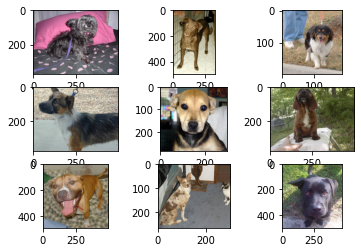

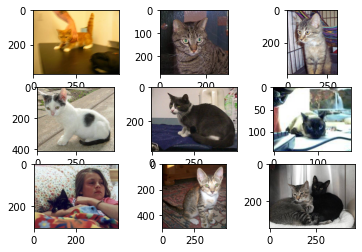

In [7]:
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)

plt.show()

# Cats
for i in range(9): 
    plt.subplot(330 + 1 + i)    
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

**Pre-Process Photos into Standard Directories:**

Alternatively, you can load all the images using Keras Image data preprocessing, but will be slower to execute.

The API we are using for this project prefers the data to be organized into **train/** and **test/** directories.

The directories will be organized as below:
> dataset_dogs_vs_cats


*   train
  *   cats

  *   dogs


*   test
  *   cats

  *   dogs

In [8]:
# organize dataset into a useful structure
from os import makedirs  # this is for creating directories
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

The following code will randomly select 25% of the images (6,250 images) to be used in a test dataset.

In [9]:
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25 

# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

After running the code, you can check the directories by clicking the "Files" on the left panel of colab. 

You should have a new **dataset_dogs_vs_cats/** now.


#Section 3: Develop a Baseline Convolutional Neural Network(CNN) Model

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

**VGG- Network** is a convolutional neural network model proposed by K.Simonyan and A.Zisserman in the paper [“Very Deep Convolutional Networks for Large-Scale Image Recognition”](https://arxiv.org/abs/1409.1556). This architecture achieved top-5 test accuracy of 92.7% in ImageNet, which has over 14 million images belonging to 1000 classes.
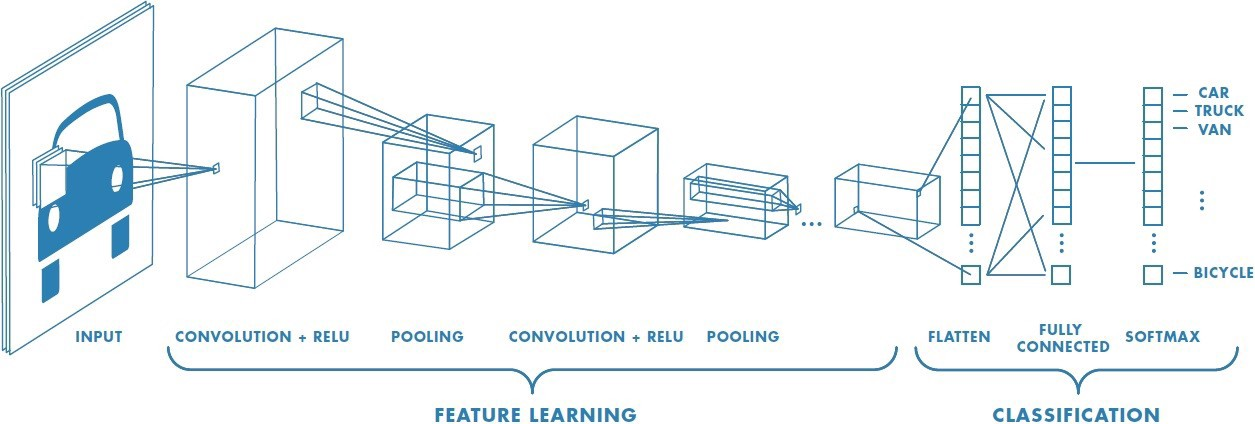

The architecture involves stacking **convolutional 2D layers** with small 3×3 filters followed by a **max pooling 2D layer**. Combining the two, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. **Padding** is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.


The main purpose of the activation function is to introduce the property of non-linearity into the model.
**ReLU** stands for **rectified linear activation function**, and it is a commonly used activation function by default for performing a majority of the deep learning tasks.

In here, we use **Stochastic Gradient Descent(SGD)** to build the model, which performs a parameter update for each training. 

The **learning rate** determines the size of the steps we take to reach the target. The **momentum** is a method that helps accelerate SGD in the relevant direction and dampens oscillations. We are using a conservative learning rate of 0.001 and a usual momentum of 0.9. 

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 72.331


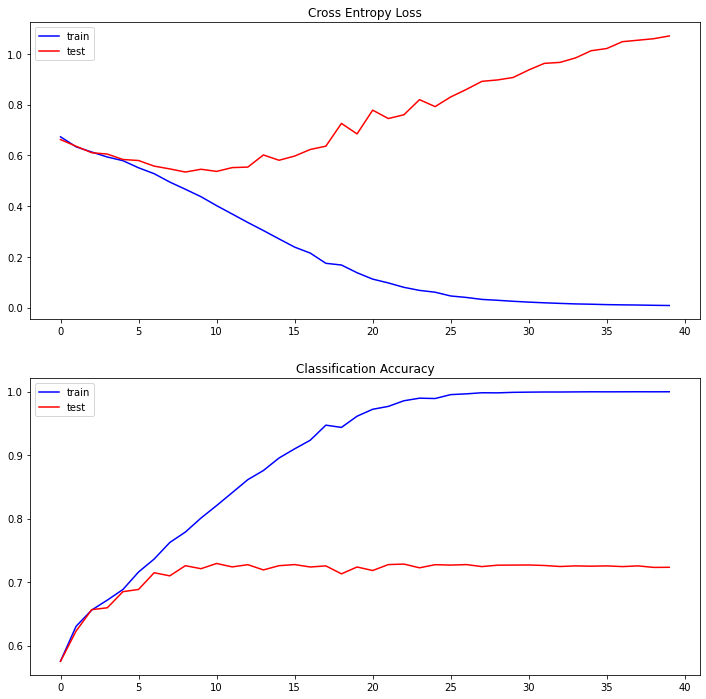

Total time for the model processing: 0:52:05.913566


In [ ]:
# baseline model with One Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


# run the test for evaluating a model
def run_test():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0) # scale the pixel values to the range of 0-1.
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))  # batch size represents the amount of sample in one iteration.
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	plot_diagnostics(history)
 
run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

[**Cross-Entropy**](https://towardsdatascience.com/what-is-cross-entropy-3bdb04c13616) is a loss function that can be used to quantify the difference between two probability distributions. We calculate the cross-entropy by taking negative logs on probabilities of the event. Generally, the smaller the cross entropy is, the better the model will be.

Blue: Train dataset / Red: Test dataset

Reviewing the plots, the model has overfit the training dataset at about 7 epochs.


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 77.788


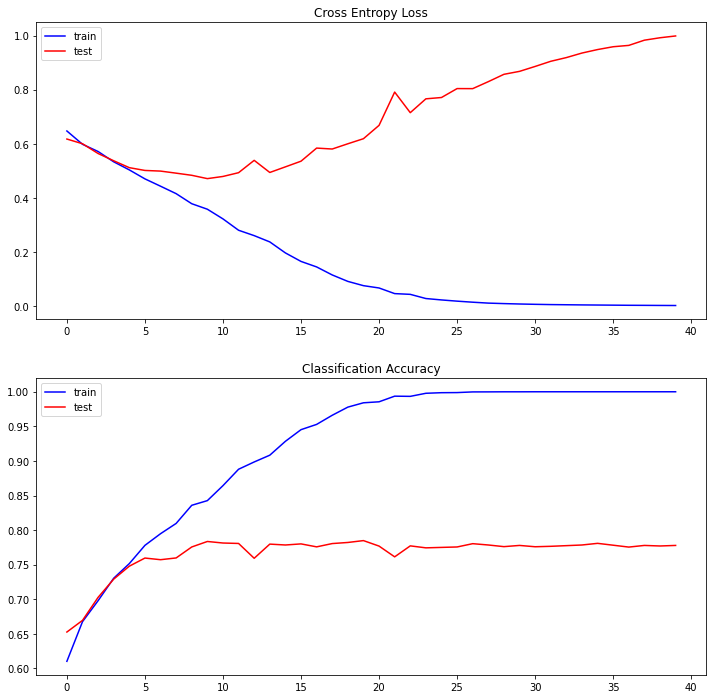

Total time for the model processing: 0:50:36.685949


In [ ]:
# baseline model with Two Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test for evaluating a model
def run_test():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	plot_diagnostics(history)
 
run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Blue: Train dataset / Red: Test dataset

Reviewing the plots, the model has overfit the training dataset at about 6 epochs.

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/40
293/293 [==============================] - 74s 249ms/step - loss: 0.5709 - accuracy: 0.7135 - val_loss: 0.9632 - val_accuracy: 0.5458
Epoch 2/40
293/293 [==============================] - 73s 249ms/step - loss: 0.4116 - accuracy: 0.8099 - val_loss: 0.5110 - val_accuracy: 0.7600
Epoch 3/40
293/293 [==============================] - 72s 247ms/step - loss: 0.3206 - accuracy: 0.8616 - val_loss: 0.4634 - val_accuracy: 0.7906
Epoch 4/40
293/293 [==============================] - 73s 248ms/step - loss: 0.2254 - accuracy: 0.9153 - val_loss: 0.5074 - val_accuracy: 0.7763
Epoch 5/40
293/293 [==============================] - 73s 249ms/step - loss: 0.1425 - accuracy: 0.9549 - val_loss: 0.5257 - val_accuracy: 0.7918
Epoch 6/40
293/293 [==============================] - 73s 248ms/step - loss: 0.0798 - accuracy: 0.9834 - val_loss: 0.5341 - val_accuracy: 0.7958
Epoch 7/40
293/293 [=========================

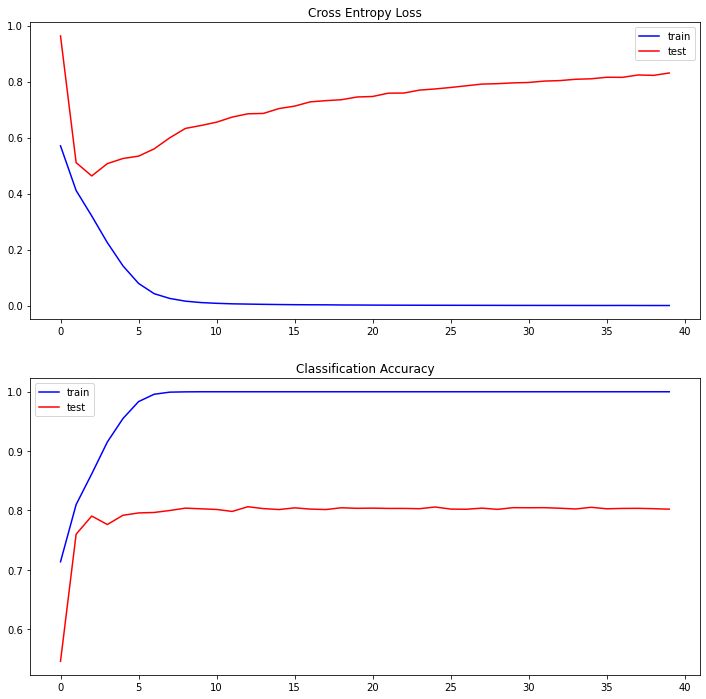

Total time for the model processing: 0:48:53.359000


In [ ]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	#compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

#run the test for evaluating a model
def run_test():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  plot_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

# Section 4: Dropout regularization

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/120
293/293 [==============================] - 78s 265ms/step - loss: 0.7351 - accuracy: 0.5344 - val_loss: 0.6899 - val_accuracy: 0.5496
Epoch 2/120
293/293 [==============================] - 76s 261ms/step - loss: 0.6827 - accuracy: 0.5573 - val_loss: 0.6893 - val_accuracy: 0.5562
Epoch 3/120
293/293 [==============================] - 76s 261ms/step - loss: 0.6752 - accuracy: 0.5696 - val_loss: 0.6867 - val_accuracy: 0.5185
Epoch 4/120
293/293 [==============================] - 76s 261ms/step - loss: 0.6713 - accuracy: 0.5797 - val_loss: 0.6854 - val_accuracy: 0.5283
Epoch 5/120
293/293 [==============================] - 76s 261ms/step - loss: 0.6665 - accuracy: 0.5879 - val_loss: 0.6812 - val_accuracy: 0.5491
Epoch 6/120
293/293 [==============================] - 77s 262ms/step - loss: 0.6617 - accuracy: 0.5967 - val_loss: 0.6804 - val_accuracy: 0.5505
Epoch 7/120
293/293 [==================

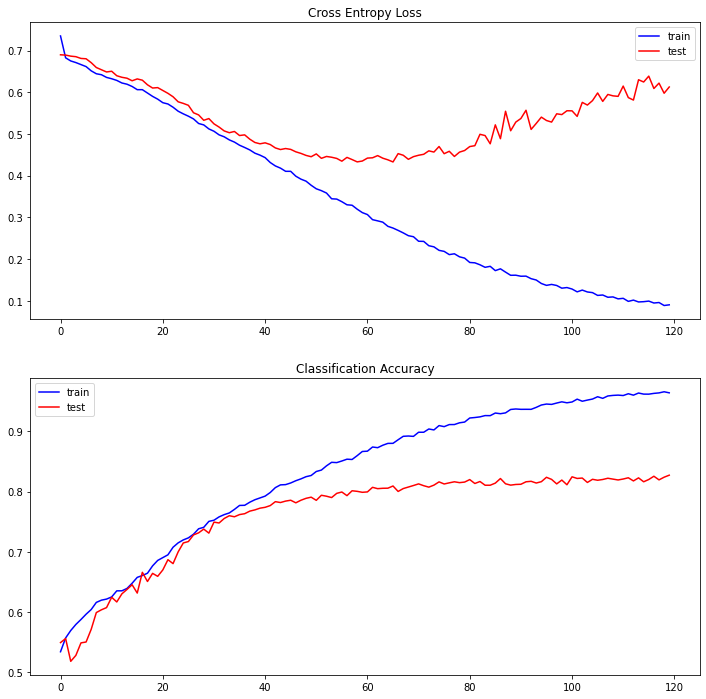

Total time for the model processing: 2:35:18.788857


In [ ]:
# dropout regularization with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  #opt = Adam(learning_rate=0.001)
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#run the test for evaluating a model
def run_test():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=120, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  plot_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

# Section 5: Image Data Augmentation

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/120
293/293 [==============================] - 91s 310ms/step - loss: 0.6684 - accuracy: 0.5849 - val_loss: 0.7087 - val_accuracy: 0.5397
Epoch 2/120
293/293 [==============================] - 90s 309ms/step - loss: 0.6324 - accuracy: 0.6399 - val_loss: 0.6053 - val_accuracy: 0.6675
Epoch 3/120
293/293 [==============================] - 91s 309ms/step - loss: 0.6142 - accuracy: 0.6635 - val_loss: 0.6072 - val_accuracy: 0.6635
Epoch 4/120
293/293 [==============================] - 90s 308ms/step - loss: 0.5881 - accuracy: 0.6899 - val_loss: 0.5671 - val_accuracy: 0.7028
Epoch 5/120
293/293 [==============================] - 90s 308ms/step - loss: 0.5768 - accuracy: 0.6997 - val_loss: 0.5506 - val_accuracy: 0.7185
Epoch 6/120
293/293 [==============================] - 90s 308ms/step - loss: 0.5626 - accuracy: 0.7115 - val_loss: 0.5743 - val_accuracy: 0.7022
Epoch 7/120
293/293 [==================

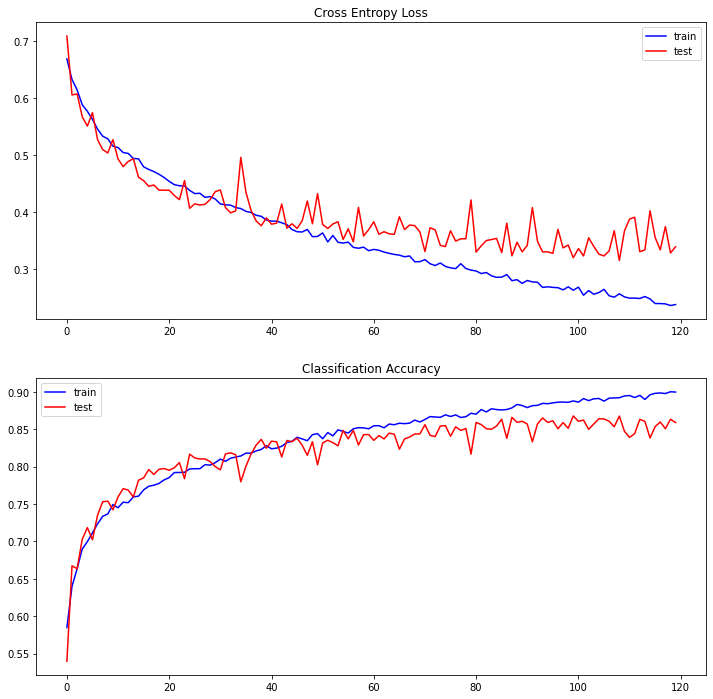

Total time for the model processing: 2:58:01.353348


In [ ]:
# image data augmentation with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = Adam(learning_rate=0.001)
  #opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#run the test for evaluating a model
def run_test():
  # define model
  model = define_model()
  # create data generator
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    width_shift_range=0.1, rotation_range=30, shear_range=0.2, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=60, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  plot_diagnostics(history)

run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/120
293/293 [==============================] - 88s 299ms/step - loss: 0.6881 - accuracy: 0.5559 - val_loss: 0.6722 - val_accuracy: 0.5750
Epoch 2/120
293/293 [==============================] - 87s 298ms/step - loss: 0.6650 - accuracy: 0.5984 - val_loss: 0.6504 - val_accuracy: 0.6200
Epoch 3/120
293/293 [==============================] - 87s 298ms/step - loss: 0.6520 - accuracy: 0.6181 - val_loss: 0.6437 - val_accuracy: 0.6281
Epoch 4/120
293/293 [==============================] - 87s 297ms/step - loss: 0.6415 - accuracy: 0.6303 - val_loss: 0.6333 - val_accuracy: 0.6365
Epoch 5/120
293/293 [==============================] - 87s 297ms/step - loss: 0.6321 - accuracy: 0.6417 - val_loss: 0.6244 - val_accuracy: 0.6487
Epoch 6/120
293/293 [==============================] - 87s 296ms/step - loss: 0.6244 - accuracy: 0.6520 - val_loss: 0.6319 - val_accuracy: 0.6295
Epoch 7/120
293/293 [==================

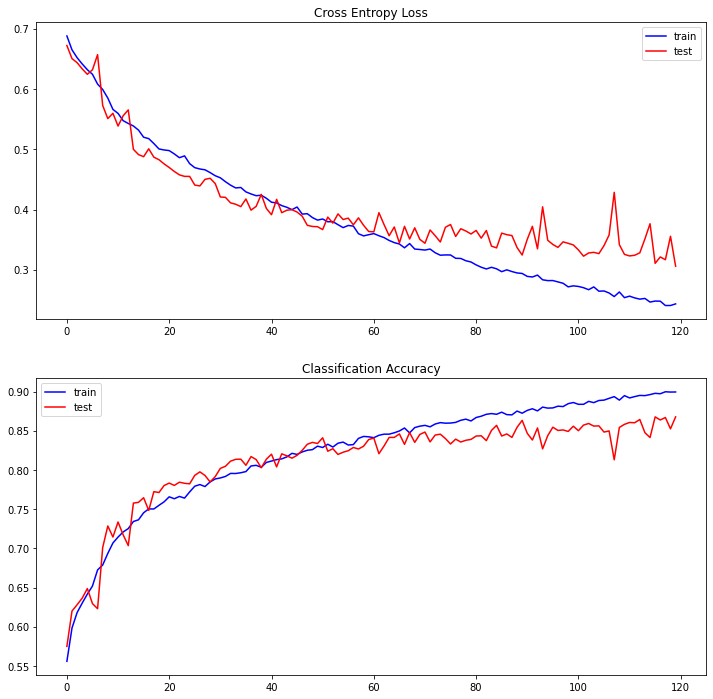

Total time for the model processing: 2:53:07.327291


In [ ]:
# Combination of dropout and image augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#run the test for evaluating a model
def run_test():
  # define model
  model = define_model()
  # create data generator
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    shear_range=0.2, rotation_range=30, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=120, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  plot_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))


#Section 6: Transfer Learning Using VGG-16 Model from Keras API

**Transfer learning** is a technique in machine learning that uses a well trained model to solve similar problems. Normally these models are trained with millions of data and longer training time. For example, the algorithm that learned to recognize bicycles can be applied to recognize motorcycles, since they have similar patterns.

This model can be found in [Keras API Applications page](https://keras.io/api/applications/)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

58900480/58889256 [==============================] - 1s 0us/step
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 104s 322ms/step - loss: 0.2238 - accuracy: 0.9640 - val_loss: 0.0631 - val_accuracy: 0.9762
Epoch 2/10
293/293 [==============================] - 94s 319ms/step - loss: 0.0249 - accuracy: 0.9911 - val_loss: 0.0729 - val_accuracy: 0.9772
Epoch 3/10
293/293 [==============================] - 93s 317ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0791 - val_accuracy: 0.9787
Epoch 4/10
293/293 [==============================] - 94s 320ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0873 - val_accuracy: 0.9792
Epoch 5/10
293/293 [==============================] - 94s 320ms/step - loss: 6.2633e-04 - accuracy: 0.9999 - val_loss: 0.0921 - val_accuracy: 0.9791
Epoch 6/10
293/293 [==============================] - 94s 320ms/step - loss: 4.1142e-04 - accuracy: 0.9999 - val_loss: 0

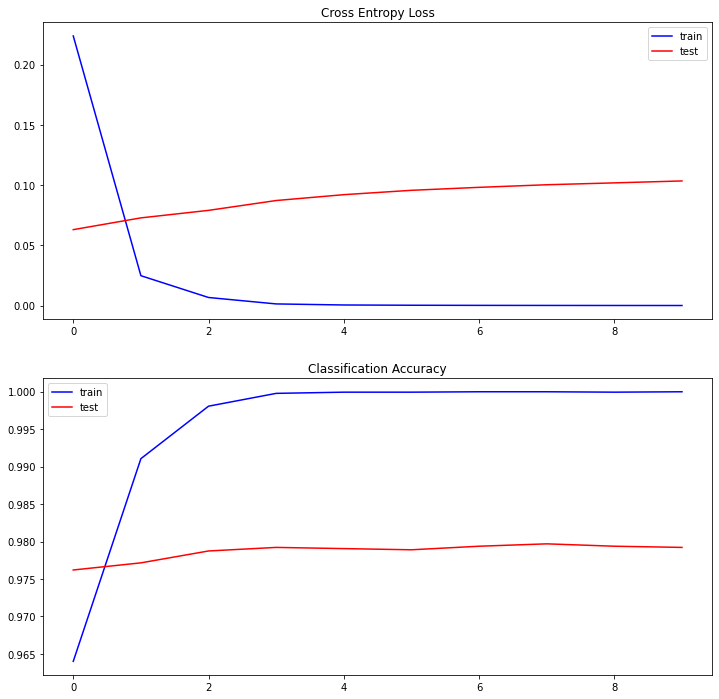

Total time for the model processing: 0:16:16.946698


In [ ]:
# Transfer learning with VGG16 Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

#define CNN model
def define_model():
  #load model
  # we do not load the fully-connected output layers (which make prediction)
  model = VGG16(include_top=False, input_shape=(224,224,3)) 
  # freeze the laoded layers from VGG16 as untrainable
  for layer in model.layers:
    layer.trainable = False

  #add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  #define new model
  model = Model(inputs=model.inputs, outputs=output)
  #compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

  #run the test for evaluating a model
def run_test():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(featurewise_center=True)
  # specify mean values for centering (from imagenet)
  datagen.mean = [123.68, 116.779, 103.939]
  # prepare iterator
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  plot_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))